In [1]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import evaluate
import numpy as np
from transformers import DataCollatorWithPadding

In [3]:
from datasets import load_dataset

dataset_dict = load_dataset("hebashakeel/Bert-classification-wellness")

README.md:   0%|          | 0.00/515 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/93.2k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/21.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/239 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/241 [00:00<?, ? examples/s]

In [4]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1118
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 239
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 241
    })
})

In [5]:
from huggingface_hub import login
login()

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model with classification head
tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("mental/mental-bert-base-uncased", num_labels=4)


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
id2label = {0: "PA", 1: "IVA", 2: "SA", 3: "SEA"}
label2id = {"PA": 0, "IVA": 1, "SA": 2, "SEA": 3} 

In [ ]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

In [9]:
# freeze base model parameters
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# unfreeze base model pooling layers
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

In [ ]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

In [10]:
# define text preprocessing
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [11]:
# tokenize all datasets
tokenized_data = dataset_dict.map(preprocess_function, batched=True)
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1118 [00:00<?, ? examples/s]

Map:   0%|          | 0/239 [00:00<?, ? examples/s]

Map:   0%|          | 0/241 [00:00<?, ? examples/s]

In [15]:
import numpy as np
from scipy.special import softmax
from sklearn.metrics import roc_auc_score, accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Apply softmax to get probabilities
    probabilities = softmax(predictions, axis=1)
    
    # Compute AUC for each class in a one-vs-rest fashion
    aucs = []
    for class_idx in range(4): 
        binary_labels = (labels == class_idx).astype(int)
        auc = roc_auc_score(binary_labels, probabilities[:, class_idx])
        aucs.append(auc)
    
    avg_auc = np.round(np.mean(aucs), 3)
    
    # Predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Compute accuracy
    acc = np.round(accuracy_score(labels, predicted_classes), 3)
    
    # Compute class-wise precision, recall, and F1 score
    class_precision = {}
    class_recall = {}
    class_f1 = {}
    for class_idx in range(4):
        tp = np.sum((predicted_classes == class_idx) & (labels == class_idx))
        fp = np.sum((predicted_classes == class_idx) & (labels != class_idx))
        fn = np.sum((predicted_classes != class_idx) & (labels == class_idx))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        class_precision[f"Precision_Class_{class_idx}"] = np.round(precision, 3)
        class_recall[f"Recall_Class_{class_idx}"] = np.round(recall, 3)
        class_f1[f"F1_Score_Class_{class_idx}"] = np.round(f1, 3)
    
    return {
        "Accuracy": acc, 
        "AUC": avg_auc,
        **class_precision,
        **class_recall,
        **class_f1
    }

In [19]:
from transformers import TrainingArguments, EarlyStoppingCallback

# Define hyperparameters
lr = 2e-4
batch_size = 8
num_epochs = 10

# Set up training arguments with early stopping configuration
training_args = TrainingArguments(
    output_dir="mentalBERT-wellness-classifier",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",  # Change to "steps" if troubleshooting
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # or use "eval_accuracy" if that's your focus
    greater_is_better=False,  # Set to True if maximizing a metric like accuracy
)

# Add early stopping callback with specified patience
callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
) 

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc,Precision Class 0,Precision Class 1,Precision Class 2,Precision Class 3,Recall Class 0,Recall Class 1,Recall Class 2,Recall Class 3,F1 Score Class 0,F1 Score Class 1,F1 Score Class 2,F1 Score Class 3
1,0.921200,0.834594,0.689000,0.875000,0.667000,0.850000,0.652000,0.694000,0.679000,0.630000,0.714000,0.694000,0.673000,0.723000,0.682000,0.694000
2,0.777400,0.816722,0.614000,0.892000,0.690000,0.875000,0.710000,0.546000,0.547000,0.519000,0.349000,0.847000,0.611000,0.651000,0.468000,0.664000
3,0.725800,0.740188,0.705000,0.896000,0.691000,0.842000,0.708000,0.686000,0.717000,0.593000,0.730000,0.714000,0.704000,0.696000,0.719000,0.700000
4,0.694300,0.787104,0.647000,0.905000,0.767000,0.875000,0.725000,0.569000,0.434000,0.519000,0.587000,0.837000,0.554000,0.651000,0.649000,0.678000
5,0.668900,0.706577,0.705000,0.908000,0.708000,0.889000,0.721000,0.667000,0.642000,0.593000,0.698000,0.776000,0.673000,0.711000,0.710000,0.717000
6,0.638900,0.707871,0.718000,0.908000,0.720000,0.882000,0.754000,0.675000,0.679000,0.556000,0.683000,0.806000,0.699000,0.682000,0.717000,0.735000
7,0.620000,0.719345,0.693000,0.909000,0.696000,0.889000,0.780000,0.630000,0.604000,0.593000,0.619000,0.816000,0.646000,0.711000,0.690000,0.711000
8,0.617900,0.727660,0.689000,0.910000,0.708000,0.889000,0.795000,0.618000,0.642000,0.593000,0.556000,0.827000,0.673000,0.711000,0.654000,0.707000
9,0.601100,0.712653,0.689000,0.911000,0.711000,0.882000,0.750000,0.630000,0.604000,0.556000,0.619000,0.816000,0.653000,0.682000,0.678000,0.711000
10,0.602300,0.703041,0.697000,0.911000,0.696000,0.889000,0.750000,0.645000,0.604000,0.593000,0.667000,0.796000,0.646000,0.711000,0.706000,0.712000


TrainOutput(global_step=1400, training_loss=0.686764019557408, metrics={'train_runtime': 55.4333, 'train_samples_per_second': 201.684, 'train_steps_per_second': 25.256, 'total_flos': 331326490493856.0, 'train_loss': 0.686764019557408, 'epoch': 10.0})

In [21]:
from transformers import Trainer

# Assuming `trainer` is your Trainer instance and `test_dataset` is your test dataset
test_results = trainer.evaluate(tokenized_data["test"])

# Print the results
print("Test Results on the Best Model:")
for key, value in test_results.items():
    print(f"{key}: {value}")


Test Results on the Best Model:
eval_loss: 0.7030413746833801
eval_Accuracy: 0.697
eval_AUC: 0.911
eval_Precision_Class_0: 0.696
eval_Precision_Class_1: 0.889
eval_Precision_Class_2: 0.75
eval_Precision_Class_3: 0.645
eval_Recall_Class_0: 0.604
eval_Recall_Class_1: 0.593
eval_Recall_Class_2: 0.667
eval_Recall_Class_3: 0.796
eval_F1_Score_Class_0: 0.646
eval_F1_Score_Class_1: 0.711
eval_F1_Score_Class_2: 0.706
eval_F1_Score_Class_3: 0.712
eval_runtime: 0.6052
eval_samples_per_second: 398.233
eval_steps_per_second: 51.225
epoch: 10.0


In [22]:
# apply model to validation dataset
predictions = trainer.predict(tokenized_data["validation"])

# Extract the logits and labels from the predictions object
logits = predictions.predictions
labels = predictions.label_ids

# Use your compute_metrics function
metrics = compute_metrics((logits, labels))
print(metrics)

{'Accuracy': 0.678, 'AUC': 0.892, 'Precision_Class_0': 0.75, 'Precision_Class_1': 0.857, 'Precision_Class_2': 0.678, 'Precision_Class_3': 0.622, 'Recall_Class_0': 0.588, 'Recall_Class_1': 0.581, 'Recall_Class_2': 0.656, 'Recall_Class_3': 0.771, 'F1_Score_Class_0': 0.659, 'F1_Score_Class_1': 0.692, 'F1_Score_Class_2': 0.667, 'F1_Score_Class_3': 0.688}


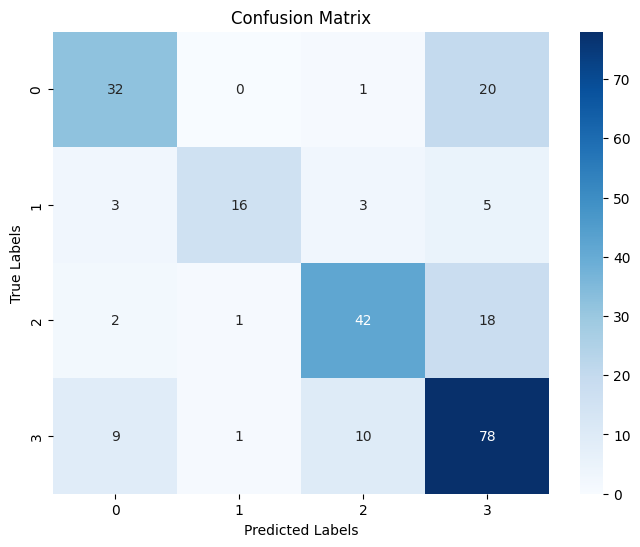

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.70      0.60      0.65        53
     Class 1       0.89      0.59      0.71        27
     Class 2       0.75      0.67      0.71        63
     Class 3       0.64      0.80      0.71        98

    accuracy                           0.70       241
   macro avg       0.74      0.66      0.69       241
weighted avg       0.71      0.70      0.70       241



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predictions = trainer.predict(tokenized_data["test"])

predicted_classes = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(4), yticklabels=range(4))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Step 3: Print classification report
class_report = classification_report(true_labels, predicted_classes, target_names=[f"Class {i}" for i in range(4)])
print("Classification Report:\n", class_report)

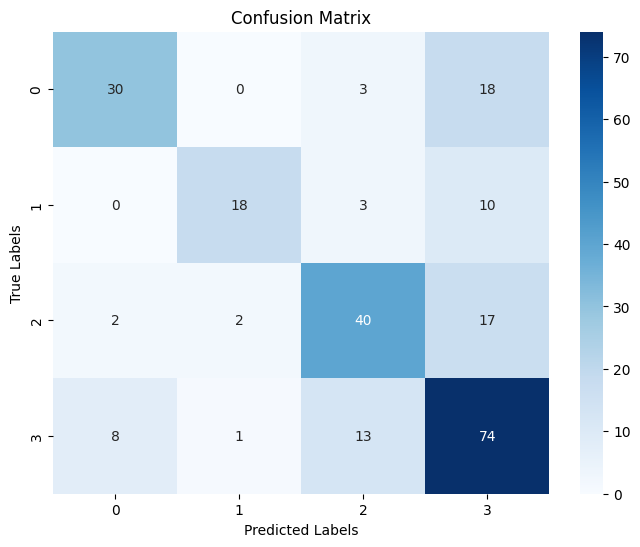

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.75      0.59      0.66        51
     Class 1       0.86      0.58      0.69        31
     Class 2       0.68      0.66      0.67        61
     Class 3       0.62      0.77      0.69        96

    accuracy                           0.68       239
   macro avg       0.73      0.65      0.68       239
weighted avg       0.69      0.68      0.68       239



In [25]:
predictions = trainer.predict(tokenized_data["validation"])

predicted_classes = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(4), yticklabels=range(4))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(true_labels, predicted_classes, target_names=[f"Class {i}" for i in range(4)])
print("Classification Report:\n", class_report)

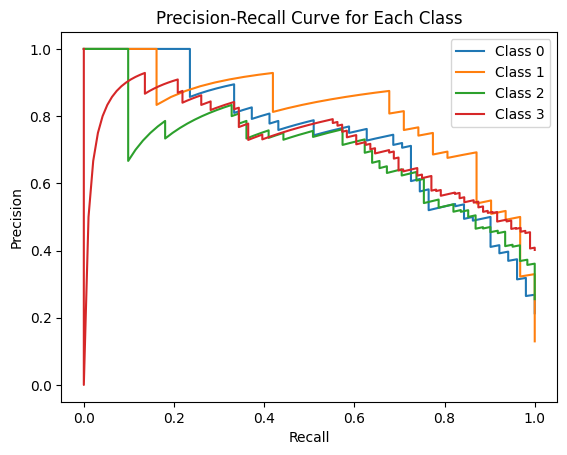

In [26]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Assuming predictions and true_labels are defined as in previous code
for i in range(4):
    binary_labels = (true_labels == i).astype(int)
    probabilities = predictions.predictions[:, i]

    precision, recall, _ = precision_recall_curve(binary_labels, probabilities)
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.show()

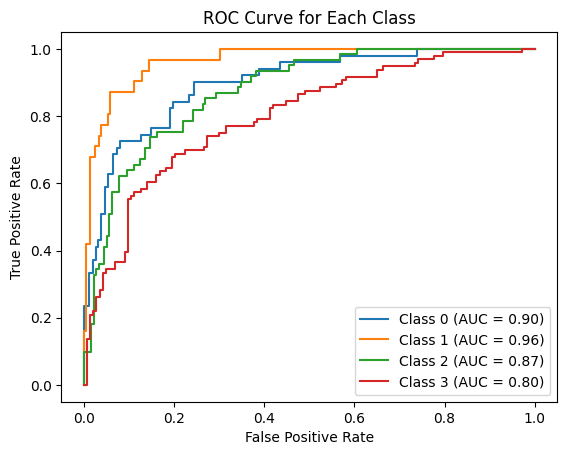

In [27]:
from sklearn.metrics import roc_curve, auc

for i in range(4):
    binary_labels = (true_labels == i).astype(int)
    probabilities = predictions.predictions[:, i]

    fpr, tpr, _ = roc_curve(binary_labels, probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# push model to hub
trainer.push_to_hub()